In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import pandas as pd
%matplotlib inline

<h2>Load Train and Sample Test Data</h2>

In [2]:
# PAGE 16. First we generated 10 means mk from a bivariate Gaussian
#          distribution N((1,0),I) and labeled this class BLUE.
blue_means = np.array([[-0.25343316,  1.7414788], [ 0.26669318,  0.3712341], 
                       [ 2.09646921,  1.2333642], [-0.06127272, -0.2086791], 
                       [ 2.70354085,  0.5968283], [ 2.37721198, -1.1864147],
                       [ 1.05690759, -0.6838939], [ 0.57888354, -0.0683458],
                       [ 0.62425213,  0.5987384], [ 1.67335495, -0.2893159]])
# PAGE 16. Similarly, 10 more were drawn from N((0,1),I) and labeled class ORANGE.
brown_means = np.array([[ 1.19936869,  0.2484086], [-0.30256110,  0.9454190],
                        [ 0.05727232,  2.4197271], [ 1.32932203,  0.8192260],
                        [-0.07938424,  1.6138017], [ 3.50792673,  1.0529863],
                        [ 1.61392290,  0.6717378], [ 1.00753570,  1.3683071],
                        [-0.45462141,  1.0860697], [-1.79801805,  1.9297806]])

In [3]:
# PAGE 16. Then for each class we generated 100 observations as follows: 
#          for each observation, we picked an mk at random with probability 1/10, 
#          and then generated a N(mk,I/5), thus leading to a mixture of Gaussian 
#          clusters for each class.
def sample(n):
    means = np.vstack((blue_means, brown_means))
    # we'll use GaussianMixture from sklearn.mixture for random sampling 
    gm = GaussianMixture(n_components=20, covariance_type='spherical', means_init=means)
    # fitting 20 spherical components to means and setting cov to 1/5
    gm.fit(means)
    gm.covariances_ = [1/5]*20
    X, y = gm.sample(n) # y is the component's index
    y = 1*(y>=10)       # when the index < 10, then point is BLUE (0)
    return X, y

# sample test for accuracy score calculation
X_test, y_test = sample(10000)

In [4]:
# load training data set from file
df = pd.read_csv("../data/mixture.txt")
X_train = df[['x1', 'x2']].values
y_train = df.y.values

<h2>Prepare Plotting Functions</h2>

In [5]:
# define gray, blue and orange colors
BLUE, ORANGE, GRAY1, GRAY4, BLUE1 = '#57B5E8', '#E69E00', '#231F20', '#646369', '#174A7E'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

In [6]:
# draws train data scatter plot with title
def plot_train_data(title):
    fig, ax1 = plt.subplots(figsize=(2.8, 2.8), dpi=110)
    ax1.set_aspect(1.3)
    ax1.scatter(X_train[:,0], X_train[:,1], s=18, facecolors='none', 
                edgecolors=np.array([BLUE, ORANGE])[y_train])
    ax1.tick_params(bottom=False, left=False, 
                    labelleft=False, labelbottom=False)
    ax1.set_xlim(-2.6, 4.2)
    ax1.set_ylim(-2.0, 2.9)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax1.text(-2.6, 3.2, title, color=GRAY4, fontsize=9)
    for spine_name in ['top', 'left', 'right', 'bottom']:
        ax1.spines[spine_name].set_color(GRAY1)
    return fig, ax1

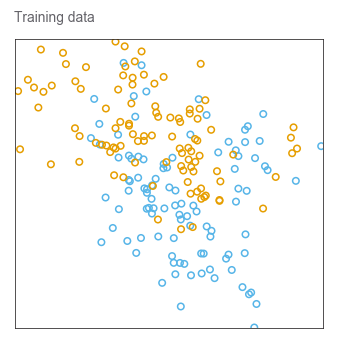

In [7]:
_, _ = plot_train_data('Training data')

In [8]:
# given prediction function calculates X points on n x n grid
# and corresponding predicted classes for ploting background dots
def predict_grid(n1, n2, predict_function):
    x1_vals = np.linspace(-2.6, 4.2, n1)
    x2_vals = np.linspace(-2.0, 2.9, n2)
    X = np.transpose([np.tile(x1_vals, n2), np.repeat(x2_vals, n1)])
    y = predict_function(X)
    return X, y

# given prediction function calculates X0 and X1 n x n meshgrids
# and corresponing predicted classes meshgrid for plotting decision boundary
def predict_meshgrid(n1, n2, predict_function):
    X, y = predict_grid(n1, n2, predict_function)
    return X[:,0].reshape(n1, n2), X[:,1].reshape(n1, n2), y.reshape(n1, n2)

# plots train data, model decision bounary (by it's predict function) 
# and background points
def plot_model(predict_function, title):
    fig, ax1 = plot_train_data(title)
    # plot background dots
    X, y = predict_grid(69, 99, predict_function)
    ax1.scatter(X[:,0], X[:,1], marker='.', lw=0, s=2, 
                c=np.array([BLUE, ORANGE])[y])
    # plot decision boundary
    X0, X1, Y = predict_meshgrid(1000, 1000, predict_function)
    ax1.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax1

<h2>Calculate Bayes Error and the Optimal Bayes Decision Boundary</h2>

In [9]:
# having known all means and convariances we build an optimal Bayes classifier
def optimal_bayes_predict(X):
    cov = np.eye(2)/5
    # convert means to frozen random variables for pdf calculation
    blue_rvs = [multivariate_normal(blue_means[i], cov) for i in range(10)]
    brown_rvs = [multivariate_normal(brown_means[i], cov) for i in range(10)]
    p_blue = np.sum(np.array([rv.pdf(X) for rv in blue_rvs]), axis=0)
    p_brown = np.sum(np.array([rv.pdf(X) for rv in brown_rvs]), axis=0)
    y_hat = 1*(p_brown>p_blue)
    return y_hat

In [10]:
# calculate the optimal Bayes error rate on the test data
bayes_error_rate = mean_absolute_error(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2033


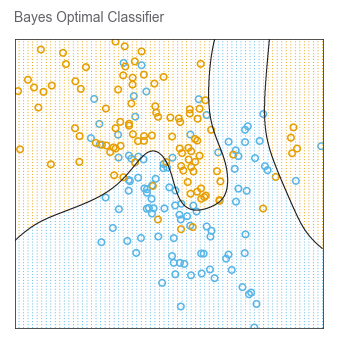

In [11]:
# test prepare_model_plot for the optimal Bayes
_, _ = plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier')

<h2>More Plotting Functions</h2>

In [12]:
# save Bayes meshgrids for optimal decision boundary plotting
X0_bayes, X1_bayes, Y_bayes = predict_meshgrid(1000, 1000, optimal_bayes_predict)

# plot model with background Bayes optimal decision boundary and stat
def plot_model_detailed(predict_function, title):
    fig, ax1 = plot_model(predict_function, title)
    ax1.contour(X0_bayes, X1_bayes, Y_bayes, [0.5], colors='purple', 
                linewidths=[0.5], linestyles='dashed')
    test_error_rate = mean_absolute_error(y_test, predict_function(X_test))
    train_error_rate = mean_absolute_error(y_train, predict_function(X_train))    
    parms = {'color': GRAY1, 
             'fontsize': 7, 
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
    l1 = f'Training Error: {train_error_rate:.3f}'
    l2 = f'Test Error:       {test_error_rate:.3f}'
    l3 = f'Bayes Error:    {bayes_error_rate:.3f}'
    ax1.text(-2.42, -1.35, l1, **parms)
    ax1.text(-2.42, -1.62, l2, **parms)
    ax1.text(-2.42, -1.89, l3, **parms)
    return fig, ax1    

<h2>Linear Regression</h2>

In [13]:
from sklearn.linear_model import LinearRegression

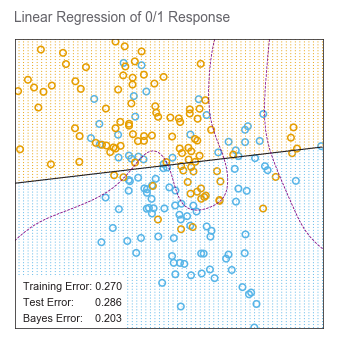

In [14]:
# PAGE 12. Let’s look at an example of the linear model in a classiﬁcation context. 
reg = LinearRegression().fit(X_train, y_train)

# PAGE 12. The ﬁtted values Y-hat are converted to a ﬁtted class variable G-hat according
#          to the rule G-hat =(ORANGE if Y-hat > 0.5, BLUE if Y-hat ≤ 0.5.
def linear_predict(X):
    return 1*(reg.predict(X)>0.5)

# PAGE 13. The line is the decision boundary deﬁned by x.T @ b = 0.5. The orange 
#          shaded region denotes that part of input space classiﬁed as ORANGE, 
#          while the blue region is classiﬁed as BLUE. 
_, _ = plot_model_detailed(linear_predict, 'Linear Regression of 0/1 Response')

<h2>Nearest-Neighbor Methods</h2>

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
# use GridSearchCV to find best parameter n_neighbors 
# through 10-folds cross-validation 
# will not use this value to be consistent with the book
parameters = {'n_neighbors': list(range(1, 50))}
knc = KNeighborsClassifier(n_neighbors=1)
grid = GridSearchCV(knc, parameters, cv=10)
grid.fit(X_train, y_train)
grid.best_params_

{'n_neighbors': 12}

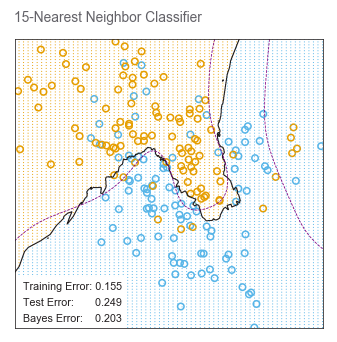

In [17]:
# PAGE 14. use 15-nearest-neighbor averaging of the binary coded response 
#          as the method of ﬁtting. Thus Y-hat is the proportion of ORANGE’s
#          in the neighborhood, and so assigning class ORANGE to G-hat 
#          if Y-hat > 0.5 amounts to a majority vote in the neighborhood.
knc = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
_, _ = plot_model_detailed(knc.predict, '15-Nearest Neighbor Classifier')

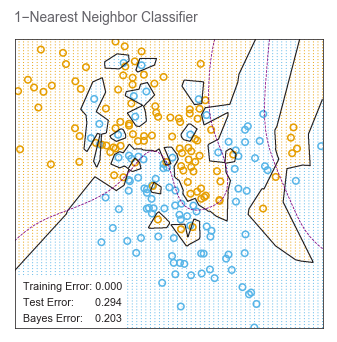

In [18]:
# PAGE 16. The classes are coded as a binary variable (BLUE = 0,ORANGE = 1), 
#          and then predicted by 1-nearest-neighbor classiﬁcation.
knc = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
_, _ = plot_model_detailed(knc.predict, '1−Nearest Neighbor Classifier')

<h2>Logistic Regression with Natural Cubic Spline Basis Expansion</h2>

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [20]:
# sklearn doesn't have natural cubic spline basis expansion
# so, let's implement it with fit-transform method to be used
# in pipeline
class NaturalCubicSplineFeatures():
    def __init__(self, knots, tensor_product=False):
        self.knots = knots
        self.tensor_product=tensor_product
    
    @staticmethod
    def dk(x, xi_k, xi_K):
        return (max(0, x-xi_k)**3) / (xi_K-xi_k)
    
    @staticmethod
    def do_nc_expansion(x, xis):
        X = np.zeros(shape=(x.shape[0], len(xis)))
        for i in range(X.shape[0]):
            X[i, 0] = 1
            X[i, 1] = x[i]
            for k in range(2, len(xis)):
                X[i, k] = NaturalCubicSplineFeatures.dk(x[i], xis[k-2], xis[-1]) - \
                          NaturalCubicSplineFeatures.dk(x[i], xis[-2], xis[-1])
        return X
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        h = []
        for i in range(X.shape[1]):
            h.append(NaturalCubicSplineFeatures.do_nc_expansion(X[:,i], self.knots[i])[:,1:])            
        if self.tensor_product:
            for j in range(h[0].shape[1]):
                for k in range(h[1].shape[1]):
                    h.append(h[0][:,j:j+1]*h[1][:,k:k+1])
        result = np.hstack(h)
        return result

In [21]:
# the book doesn't give knots positions
knots = np.array([-2, 0, 1, 3])

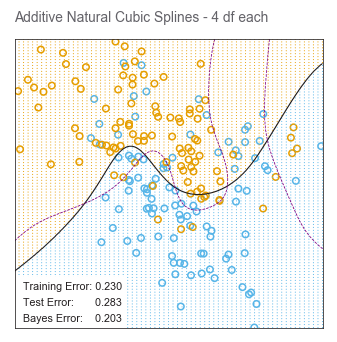

In [22]:
# PAGE 164. The upper panel shows the decision boundary of an additive 
#           logistic regression model, using natural splines in each 
#           of the two coordinates (total df = 1 + (4−1) + (4−1) = 7).
model = Pipeline([('expand', NaturalCubicSplineFeatures([knots, knots], 
                                                      tensor_product=False)),
                  ('scale', StandardScaler()),
                  ('logistic', LogisticRegression(C=1000, solver='lbfgs'))])
lrc = model.fit(X_train, y_train)
_, _ = plot_model_detailed(lrc.predict, 'Additive Natural Cubic Splines - 4 df each')

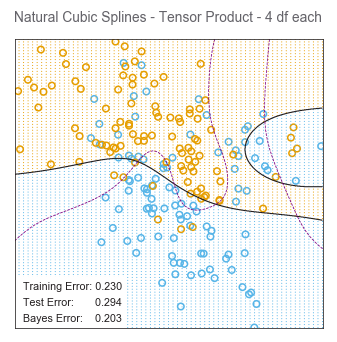

In [23]:
# PAGE 164. The lower panel shows the results of using a tensor product 
#           of natural spline bases in each coordinate (total df = 4 × 4 = 16).
model = Pipeline([('expand', NaturalCubicSplineFeatures([knots, knots], 
                                                      tensor_product=True)),
                  #('scale', StandardScaler()),
                  ('logistic', LogisticRegression(C=10000, solver='lbfgs'))])
lrc = model.fit(X_train, y_train)
_, _ = plot_model_detailed(lrc.predict, 'Natural Cubic Splines - Tensor Product - 4 df each')

<h2>Neural Networks</h2>

In [24]:
import tensorflow as tf
import math
from sklearn.preprocessing import OneHotEncoder

In [25]:
# PAGE 398. Since the scaling of the inputs determines the eﬀective scaling of the 
#           weights in the bottom layer, it can have a large eﬀect on the quality of the ﬁnal
#           solution. At the outset it is best to standardize all inputs to have mean 
#           zero and standard deviation one. This ensures all inputs are treated equally 
#           in the regularization process, and allows one to choose a meaningful range for 
#           the random starting weights.
scaler = StandardScaler().fit(X_train)
X_train_standartized = scaler.transform(X_train)

# PAGE 392. For K-class classiﬁcation, there are K units at the top, with the kth unit modeling 
#           the probability of class k. There are K target measurements Yk, k = 1,...,K, each 
#           being coded as a 0−1 variable for the kth class.
Y_train_one_hot = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()

In [26]:
session = tf.Session()

In [27]:
n_hidden = 10
initializer = tf.contrib.layers.xavier_initializer()

x = tf.placeholder(tf.float64, shape=[None, 2])
y = tf.placeholder(tf.float64, shape=[None, 2])

A = tf.Variable(initializer([2, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 2], dtype=tf.float64))
b0 = tf.Variable(initializer([2], dtype=tf.float64))

# PAGE 392. Derived features Zm are created from linear combinations of the inputs, 
#           and then the target Yk is modeled as a function of linear combinations of the Zm, 
#           The activation function σ(v) is usually chosen to be the sigmoid σ(v) = 1/(1+e−v);
Z = tf.nn.sigmoid(a0 + x@A)
T = b0 + Z@B

# PAGE 393. The output function gk(T) allows a ﬁnal transformation of the vector of outputs T. 
#           For regression we typically choose the identity function gk(T) = Tk. 
#           Early work in K-class classiﬁcation also used the identity function, but this was 
#           later abandoned in favor of the softmax function
y_hat = tf.nn.softmax(T)

# PAGE 395. For classiﬁcation we use either squared error or cross-entropy (deviance)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))

In [28]:
feed_dict = {x: X_train_standartized, 
             y: Y_train_one_hot}

In [29]:
# PAGE 395. The generic approach to minimizing R(θ) is by gradient descent, 
#           called back-propagation in this setting. Because of the compositional 
#           form of the model, the gradient can be easily derived using the chain rule 
#           for diﬀerentiation. This can be computed by a forward and backward sweep 
#           over the network, keeping track only of quantities local to each unit.
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

# PAGE 395. Typically we don’t want the global minimizer of R(θ), 
#           as this is likely to be an overﬁt solution. Instead some regularization 
#           is needed: this is achieved directly through a penalty term, 
#           or indirectly by early stopping.
admW = tf.contrib.opt.AdamWOptimizer(0.0028, learning_rate=1e-2).minimize(loss)

In [30]:
# let's write a generic training procedure 
def train_and_plot(optimizer_step, title):
    session.run(tf.global_variables_initializer())
    step = 0
    # calc initial loss
    current_loss = session.run(loss, feed_dict)
    while step < 20000:
        step += 1
        if math.log(step, 5).is_integer():
            print(f'step: {step}, current loss: {current_loss}')
        session.run(optimizer_step, feed_dict)
        current_loss = session.run(loss, feed_dict)
    print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')
    
    def nn_predict(X):
        X = scaler.transform(X)
        # PAGE 395. and the corresponding classiﬁer is G(x) = argmaxkfk(x)
        return np.argmax(session.run(y_hat, {x: X}), axis=1)
    _, _ = plot_model_detailed(nn_predict, title)

step: 1, current loss: 1.4441679398399152
step: 5, current loss: 1.2185066363655148
step: 25, current loss: 0.7022820660050819
step: 625, current loss: 0.5012398226374496
step: 3125, current loss: 0.38741065354232623
ENDED ON STEP: 20000, FINAL LOSS: 0.21124076840457967
step: 1, current loss: 0.7520212646237806
step: 5, current loss: 0.7078169221441706
step: 25, current loss: 0.5962649830327389
step: 625, current loss: 0.5003977971560548
step: 3125, current loss: 0.40384867681876296
ENDED ON STEP: 20000, FINAL LOSS: 0.36832775029605225


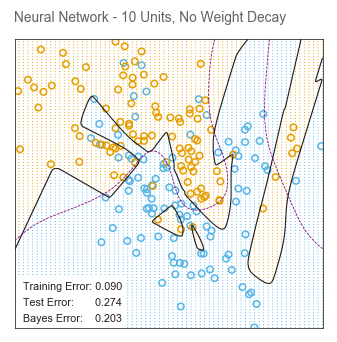

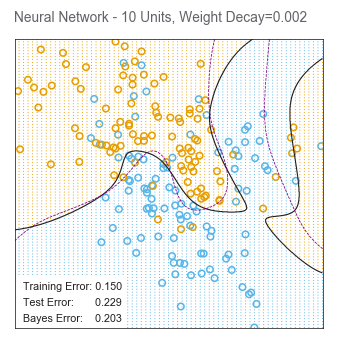

In [31]:
# PAGE 399. A neural network on the mixture example of Chapter 2. 
#           The upper panel uses no weight decay, and overﬁts the training data. 
#           The lower panel uses weight decay, and achieves close to the Bayes error rate 
#           (broken purple boundary). Both use the softmax activation function and 
#           cross-entropy error.
train_and_plot(adm, 'Neural Network - 10 Units, No Weight Decay')
train_and_plot(admW, 'Neural Network - 10 Units, Weight Decay=0.002')

<h2>Support Vector Machines and Flexible Discriminants</h2>

In [32]:
from sklearn.svm import SVC

In [33]:
# common function for plotting SVC model
def plot_svc_model(svc, title):
    sv = abs(svc.decision_function(svc.support_vectors_))
    v = svc.support_vectors_[(sv > 0.99) & (sv < 1.01)]
    fig, ax = plot_model_detailed(svc.predict, title)
    X0, X1, Y = predict_meshgrid(1000, 1000, svc.decision_function)
    _ = ax.contour(X0, X1, Y, [-1, 1], colors=GRAY1, linewidths=[0.5, 0.5], linestyles='dashed')
    ax.scatter(v[:,0], v[:,1], c='black', s=10)    

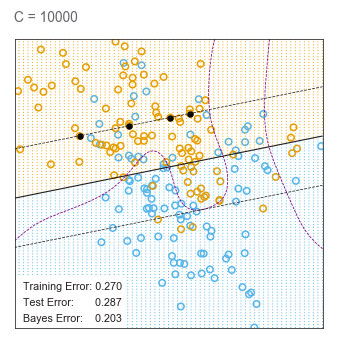

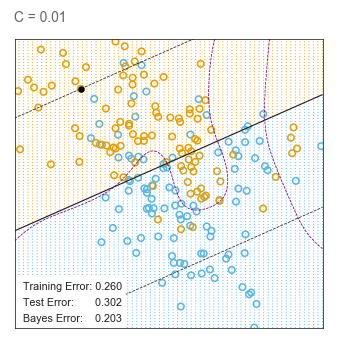

In [34]:
# PAGE 422. The linear support vector boundary for the mixture data example 
#           with two overlapping classes, for two diﬀerent values of C.
#           The broken lines indicate the margins, where f(x) = ±1. The support 
#           points (αi > 0) are all the points on the wrong side of their margin.
svc = SVC(C=10000, kernel='linear')
svc.fit(X_train, y_train)
plot_svc_model(svc, 'C = 10000')

# PAGE 422. In the upper panel 62% of the observations are support points, while 
#           in the lower panel 85% are.
svc = SVC(C=0.01, kernel='linear')
svc.fit(X_train, y_train)
plot_svc_model(svc, 'C = 0.01')
# PAGE 421.  The margin is larger for C = 0.01 than it is for C = 10,000. Hence larger values of 
#            C focus attention more on (correctly classiﬁed) points near the decision boundary, 
#            while smaller values involve data further away. Either way, misclassiﬁed points are 
#            given weight, no matter how far away. In this example the procedure is not very 
#            sensitive to choices of C, because of the rigidity of a linear boundary. 

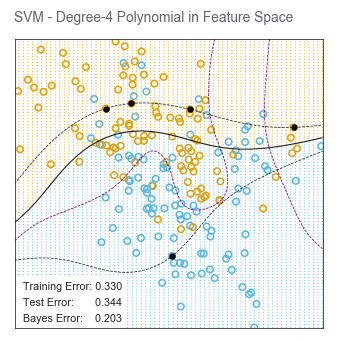

In [35]:
# the result for poly 4 looks bad
svc = SVC(kernel='poly', degree=3, C=1)
svc.fit(X_train, y_train)
plot_svc_model(svc, 'SVM - Degree-4 Polynomial in Feature Space')

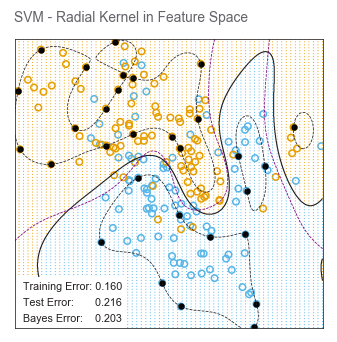

In [36]:
svc = SVC(kernel='rbf', gamma=1)
svc.fit(X_train, y_train)
plot_svc_model(svc, 'SVM - Radial Kernel in Feature Space')